# Install and Import Necessary Libraries

In [1]:
!pip install tokenization

In [2]:
import tokenization
import tensorflow as tf
import tensorflow_hub as hub
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Read The Data
The commented out parts were used initially so ignore them.

In [4]:
data_path = "/content/Table Servant Data - Sheet1 (3).csv"
max_len = 20
batch_size = 32
test_size = 0.2
val_size = 0.1

# data = []
# labels = []
# with open(data_path, "r") as f:
#   lines = f.readlines()
#   for line in lines[1:]:
#     text, label = line.strip().split(",")
#     data.append(text)
#     labels.append(label)
train_dataset = pd.read_csv(data_path)
train_dataset.head()

,INPUT,OUTPUT
0,more to table one,One
1,move to table one,One
2,whew to table,Repeat Again
3,more to cable one,One
4,move to table,Repeat Again


## Train Test Split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_dataset['               INPUT'], train_dataset['              OUTPUT'], test_size=0.3, random_state=42)


## One Hot Encode the Labels


In [6]:
label = preprocessing.LabelEncoder()
y = label.fit_transform(y_train)
y = to_categorical(y)
print(y[:5])

[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


## Introduce Bert Layer.

In [7]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

## If you run into sum error uncomment below and Re-Run the session to save your time and avoid circular imports.

In [9]:
# !pip install bert-tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 988.3 kB/s eta 0:00:00


In [10]:
from bert import tokenization

## Encode BERT

In [11]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

# Build The model
If you use this for custom purpose just take care of out layer adjust it according to your number of classes which you want output of.

In [12]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

    clf_output = sequence_output[:, 0, :]

    lay = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(32, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(3, activation='softmax')(lay)

    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

## Set Preserve unused tokens to False

In [13]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

## Train the Model.

In [15]:
max_len = 250
train_input = bert_encode(X_train, tokenizer, max_len=max_len)
test_input = bert_encode(X_test, tokenizer, max_len=max_len)
train_labels = y_train

In [16]:
labels = label.classes_
print(labels)

['One' 'Repeat Again' 'Two']


## Model Summary.

In [17]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 250)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 250)]                0         []                            
                                                                                                  
 segment_ids (InputLayer)    [(None, 250)]                0         []                            
                                                                                                  
 keras_layer (KerasLayer)    [(None, 768),                1094822   ['input_word_ids[0][0]',  

# Train the Model.

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_sh = model.fit(
    train_input, y,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 1.1924 - accuracy: 0.1290
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 34s 34s/step - loss: 1.1924 - accuracy: 0.1290 - val_loss: 0.6640 - val_accuracy: 0.6250
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 0.8650 - accuracy: 0.5161
Epoch 2: val_accuracy did not improve from 0.62500
1/1 [==============================] - 10s 10s/step - loss: 0.8650 - accuracy: 0.5161 - val_loss: 0.7408 - val_accuracy: 0.6250
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 0.9289 - accuracy: 0.5806
Epoch 3: val_accuracy did not improve from 0.62500
1/1 [==============================] - 10s 10s/step - loss: 0.9289 - accuracy: 0.5806 - val_loss: 0.9927 - val_accuracy: 0.3750


## Plot Graph vs accuracy.

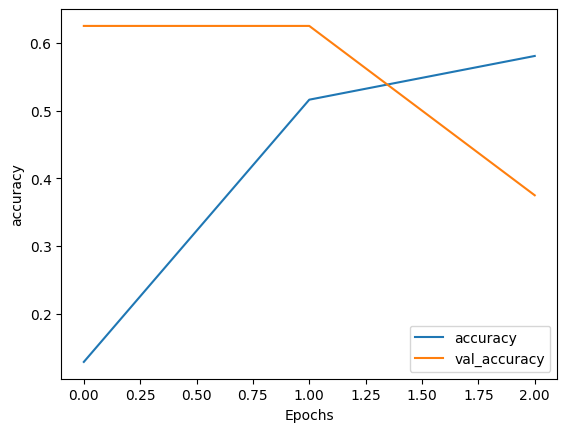

In [38]:
plot_graphs(train_sh,"accuracy")

## Predict the model to check how far it learned.

In [35]:
import tensorflow as tf

inputs = "Table One"

inputs = bert_encode(inputs,tokenizer=tokenizer,max_len=250)

predictions = model.predict(inputs)



1/1 [==============================] - 1s 1s/step


In [36]:
predictions

array([[0.20916197, 0.0794491 , 0.71138895],
       [0.20663223, 0.08071242, 0.7126553 ],
       [0.2111525 , 0.08082041, 0.70802706],
       [0.21574648, 0.08190931, 0.7023442 ],
       [0.20776927, 0.0797623 , 0.71246845],
       [0.22951064, 0.08429573, 0.6861935 ],
       [0.21020961, 0.08000824, 0.7097821 ],
       [0.19225827, 0.0764825 , 0.7312592 ],
       [0.20776927, 0.0797623 , 0.71246845]], dtype=float32)

In [33]:
predicted_classes = np.argmax(predictions, axis=1)

print("Predicted classes:", predicted_classes)

Predicted classes: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [27]:
def bert_decode(tokens, tokenizer):
    decoded_texts = []

    for token_ids in tokens:
        decoded_text = ""
        for token_id in token_ids:
            if token_id == 0:
                break
            decoded_text += tokenizer.convert_ids_to_tokens([token_id])[0] + " "
        decoded_texts.append(decoded_text.strip())

    return decoded_texts
